# Credit Card Transaction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Q1: GENERATE A LIST OF USERS WHO NEVER SPENT OVER THE CREDIT LIMIE
### Q2: FOR EACH DAY, GENERATE A LIST OF USERS WHO JUST HIT THEIR CREDIT LIMIT

In [ ]:
### SQL solution
-- Perform an outer join of two tables on unique credit card 
WITH temp AS
(
SELECT c.credit_card AS cc_c, t.credit_card AS cc_t
FROM 
	(SELECT DISTINCT credit_card FROM takehome_challenges.transactions) t
LEFT JOIN 
	(SELECT DISTINCT credit_card FROM takehome_challenges.cc_info) c
ON t.credit_card = c.credit_card

UNION

SELECT c.credit_card AS cc_c, t.credit_card AS cc_t
FROM 
	(SELECT DISTINCT credit_card FROM takehome_challenges.transactions) t
RIGHT JOIN 
	(SELECT DISTINCT credit_card FROM takehome_challenges.cc_info) c
ON t.credit_card = c.credit_card
)
SELECT COUNT(temp.cc_c), COUNT(temp.cc_t), COUNT(*) 
FROM temp;

-- 984 records are found, meaning the unique credit cards in both tables are equal. 


-- For each credit card, calculate monthly total spending
SELECT credit_card, 
	DATE_SUB(DATE(date), INTERVAL DAY(date)-1 DAY) AS month, 
    ROUND(SUM(transaction_dollar_amount), 2) AS monthly_spending
FROM takehome_challenges.transactions
GROUP BY 1,2
ORDER BY 1,2;


-- Find users who never spend over monthly limit
SELECT c.credit_card, c.credit_card_limit, t.*
FROM takehome_challenges.cc_info c
INNER JOIN (
	SELECT credit_card, 
		MAX(monthly_spending) AS max_monthly_spending
	FROM 
		(
		SELECT credit_card, 
			DATE_SUB(DATE(date), INTERVAL DAY(date)-1 DAY) AS month,
			SUM(transaction_dollar_amount) AS monthly_spending
		FROM takehome_challenges.transactions 
		GROUP BY 1, 2
		) temp
	GROUP BY 1) t 
ON t.credit_card = c.credit_card
AND t.max_monthly_spending < c.credit_card_limit;
-- 862 users who never spend over limit

-- On each day, which users are spending over limit of that month
SELECT temp.credit_card, DATE(MIN(temp.date)) AS day_over_limit, temp.transaction_dollar_amount,
	c.credit_card_limit,
    temp.acc_spd_monthly
FROM 
(
SELECT t.credit_card, 
	DATE_SUB(DATE(t.date), INTERVAL DAY(t.date)-1 DAY) AS month,
    t.date, 
    t.transaction_dollar_amount,
    SUM(t.transaction_dollar_amount) OVER 
		(PARTITION BY t.credit_card, DATE_SUB(DATE(t.date), INTERVAL DAY(t.date)-1 DAY) 
		ORDER BY t.date) AS acc_spd_monthly
FROM takehome_challenges.transactions t 
) temp 
JOIN takehome_challenges.cc_info c 
ON temp.credit_card = c.credit_card
AND temp.acc_spd_monthly > c.credit_card_limit 
GROUP BY temp.credit_card, temp.month
HAVING DATE(MIN(temp.date)) = '2015-08-20'
ORDER BY 2, 1;


-- What about all users who have cumulative spending over limit on that day
SELECT  
	DISTINCT DATE(temp.date) AS day,
    temp.credit_card
FROM 
(
SELECT t.credit_card, 
	DATE_SUB(DATE(t.date), INTERVAL DAY(t.date)-1 DAY) AS month,
    t.date, 
    t.transaction_dollar_amount,
    SUM(t.transaction_dollar_amount) OVER 
		(PARTITION BY t.credit_card, DATE_SUB(DATE(t.date), INTERVAL DAY(t.date)-1 DAY) 
		ORDER BY t.date) AS acc_spd_monthly
FROM takehome_challenges.transactions t 
) temp 
JOIN takehome_challenges.cc_info c 
ON temp.credit_card = c.credit_card
AND temp.acc_spd_monthly > c.credit_card_limit 
-- WHERE DATE(temp.date) = '2015-08-20'
ORDER BY 1, 2;

In [ ]:
### SQL solution 2

-- Find users who never spend over monthly limit
SELECT credit_card,
	MAX(monthly_spending),
    credit_card_limit
FROM	
(SELECT t.credit_card, 
	DATE_FORMAT(t.date, '%Y-%m') AS month, 
    SUM(t.transaction_dollar_amount) AS monthly_spending,
    c.credit_card_limit 
FROM takehome_challenges.transactions t 
LEFT JOIN takehome_challenges.cc_info c 
ON t.credit_card = c.credit_card
GROUP BY 1, 2) temp
GROUP BY credit_card
HAVING MAX(monthly_spending) < credit_card_limit
ORDER BY 1;



-- On each day, which users are spending over limit of that month
WITH temp AS
(
SELECT credit_card, 
	DATE_FORMAT(date, '%Y-%m') AS month, 
	date, 
    SUM(transaction_dollar_amount) OVER (PARTITION BY credit_card, DATE_FORMAT(date, '%Y-%m') ORDER BY date ASC) AS monthly_cum_spend
FROM (SELECT credit_card, DATE(date) AS date, SUM(transaction_dollar_amount) AS transaction_dollar_amount 
	FROM takehome_challenges.transactions 
    GROUP BY 1, 2) t1
) 
SELECT a.credit_card, a.date
FROM temp a 
LEFT JOIN temp b
ON a.credit_card = b.credit_card
AND a.date = DATE_ADD(b.date, INTERVAL 1 DAY)
INNER JOIN takehome_challenges.cc_info c
ON a.credit_card = c.credit_card
AND a.monthly_cum_spend > c.credit_card_limit
AND b.monthly_cum_spend < c.credit_card_limit; 

In [279]:
card = pd.read_csv('credit_card/cc_info.csv')
trans = pd.read_csv('credit_card/transactions.csv')

In [280]:
card.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [4]:
trans.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [8]:
# monthly spending of each user
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card                  294588 non-null int64
date                         294588 non-null object
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.2+ MB


In [17]:
trans['month'] = pd.to_datetime(trans['date']).dt.to_period('M')
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 6 columns):
credit_card                  294588 non-null int64
date                         294588 non-null object
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
month                        294588 non-null object
dtypes: float64(3), int64(1), object(2)
memory usage: 13.5+ MB


In [18]:
trans.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,month
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,2015-09
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,2015-10
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,2015-10
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,2015-10
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,2015-10


In [24]:
monthly_spending = trans.groupby(['credit_card', 'month']).sum()['transaction_dollar_amount'].reset_index()
monthly_spending = pd.merge(monthly_spending, card[['credit_card', 'credit_card_limit']], on='credit_card', how='left')

In [25]:
monthly_spending.head()

,credit_card,month,transaction_dollar_amount,credit_card_limit
0,1003715054175576,2015-07,162.56,20000
1,1003715054175576,2015-08,8441.51,20000
2,1003715054175576,2015-09,11281.56,20000
3,1003715054175576,2015-10,8954.21,20000
4,1013870087888817,2015-07,281.43,15000


In [30]:
monthly_spending_max = monthly_spending.groupby('credit_card').max()[['transaction_dollar_amount', 'credit_card_limit']].reset_index()

In [31]:
monthly_spending_max.head()

,credit_card,transaction_dollar_amount,credit_card_limit
0,1003715054175576,11281.56,20000
1,1013870087888817,12461.96,15000
2,1023820165155391,22741.20,28000
3,1073931538936472,2991.05,10000
4,1077622576192810,634.61,10000


In [ ]:
# users who never spent over their limit
users_never_over_limit = monthly_spending_max.loc[monthly_spending_max['transaction_dollar_amount']<monthly_spending_max['credit_card_limit'], 'credit_card']
users_never_over_limit.head()

In [102]:
# for a given day, output a list of users who hit their limit

def overlimit(day):   # input: day, format: '2015-01-01'
    trans_temp = trans.copy()
    trans_temp['day'] = pd.to_datetime(trans_temp['date']).dt.date
    trans_temp.groupby(['credit_card', 'day']).sum()['transaction_dollar_amount'].reset_index()
    day_end = pd.to_datetime(day).date()
    # day_end_before = day_end - pd.to_timedelta(1, unit='d')
    day_start = pd.to_datetime(day).to_period('M').to_timestamp().date()
    cum_spent = trans_temp.loc[(trans_temp['day']>=day_start)&(trans_temp['day']<day_end), :]\
        .groupby('credit_card').sum()['transaction_dollar_amount'].reset_index()
    cum_spent.columns = ['credit_card', 'cum_spent1']
    cum_spent2 = trans_temp.loc[(trans_temp['day']>=day_start)&(trans_temp['day']<=day_end), :]\
        .groupby('credit_card').sum()['transaction_dollar_amount'].reset_index()
    cum_spent2.columns = ['credit_card', 'cum_spent2']
    cum_spent3 = pd.merge(card[['credit_card', 'credit_card_limit']], cum_spent, on='credit_card', how='left')
    cum_spent3 = pd.merge(cum_spent3, cum_spent2, on='credit_card', how='left')
    users = cum_spent3.loc[(cum_spent3['cum_spent1']<cum_spent3['credit_card_limit'])
                                            &(cum_spent3['cum_spent2']>cum_spent3['credit_card_limit']), 'credit_card']
    return users
    

In [104]:
overlimit('2015-08-20')

681    7299183791723634
702    5723635641134781
745    8972201384562696
Name: credit_card, dtype: int64

### Q3: FRAUD DETECTION. ANY ABNORMAL SPENDDING?

Use transaction amount and lat/long distance from home address to calculate percentile values of each transaction to determine possible fraud. 

In [278]:
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def zip2latlong(row):
    location = geolocator.geocode('{}, {}'.format(row['city'], row['state']))
    loc_trans = (location.latitude, location.longitude)
    row['lat_home'] = location.latitude
    row['long_home'] = location.longitude
    return row
    
def distance_trans(row):
    loc_home = (row['lat_home'], row['long_home'])
    loc_trans = (row['Lat'], row['Long'])
    dist = great_circle(loc_trans, loc_home).miles
    return dist

In [281]:
card_dup = card.copy()
card_temp1 = card_dup[:100].apply(zip2latlong, axis=1)
card_temp2 = card_dup[100:200].apply(zip2latlong, axis=1)
card_temp3 = card_dup[200:300].apply(zip2latlong, axis=1)

GeocoderTimedOut: ('Service timed out', 'occurred at index 377')

In [282]:
card_temp4 = card_dup[300:400].apply(zip2latlong, axis=1)
card_temp5 = card_dup[400:500].apply(zip2latlong, axis=1)
card_temp6 = card_dup[500:600].apply(zip2latlong, axis=1)

In [283]:
card_temp7 = card_dup[600:700].apply(zip2latlong, axis=1)
card_temp8 = card_dup[700:800].apply(zip2latlong, axis=1)
card_temp9 = card_dup[800:900].apply(zip2latlong, axis=1)

In [284]:
card_temp10 = card_dup[900:].apply(zip2latlong, axis=1)

In [285]:
card_home_coor = pd.concat([card_temp1, card_temp2, card_temp3, card_temp4, card_temp5, card_temp6, card_temp7,
                           card_temp8, card_temp9, card_temp10], axis=0).sort_index()

In [286]:
card_home_coor.to_csv('credit_card/cc_info_home_latlon.csv')

In [287]:
card[['lat_home', 'long_home']] = card_home_coor[['lat_home', 'long_home']].apply(pd.to_numeric)

In [288]:
table = pd.merge(trans, card, on='credit_card', how='right')
table.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,lat_home,long_home
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,31.13556,-85.265459
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,31.13556,-85.265459
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,31.13556,-85.265459
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,31.13556,-85.265459
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,31.13556,-85.265459


In [289]:
table['distance'] = table.apply(distance_trans, axis=1)

In [290]:
table.to_csv('credit_card/table_comb.csv')

In [291]:
table.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,lat_home,long_home,distance
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,31.13556,-85.265459,692.272928
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,31.13556,-85.265459,686.387744
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,31.13556,-85.265459,694.268102
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,31.13556,-85.265459,693.735483
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,31.13556,-85.265459,684.528664


### PLOT HOME ZIPCODE AND TRANSACTIONS ZIPCODE

7.9804546 48.6038321 -158.8556764 -1.3524086999999998


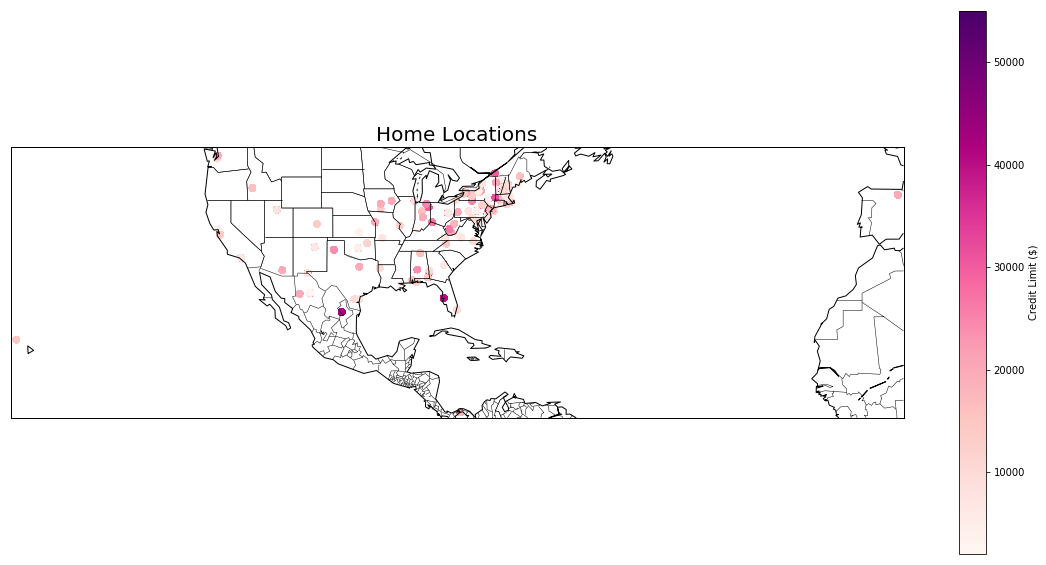

In [292]:
lat_min = table.describe().loc['min','lat_home']-1
lat_max = table.describe().loc['max','lat_home']+1
lon_min = table.describe().loc['min','long_home']-1
lon_max = table.describe().loc['max','long_home']+1
print(lat_min, lat_max, lon_min, lon_max)

from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(20,10))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)
m.drawcoastlines()
m.drawmapboundary()
#m.drawrivers()
m.drawcountries()
m.drawstates()

m.scatter(table['long_home'].tolist(), table['lat_home'].tolist(), c=table['credit_card_limit'], cmap='RdPu', latlon=True)
plt.title('Home Locations', fontsize=20)
#cbar = plt.colorbar()
plt.colorbar(label='Credit Limit ($)')
#cbar.set_label('Transaction Amount ($)', rotation=90, fontsize=20)
plt.show()

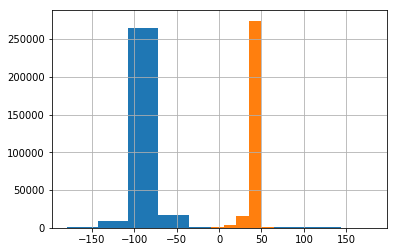

In [302]:
table['Long'].hist()
table['Lat'].hist()

-69.046553453928 79.9143300311764 -180.39288734815202 180.917513484729


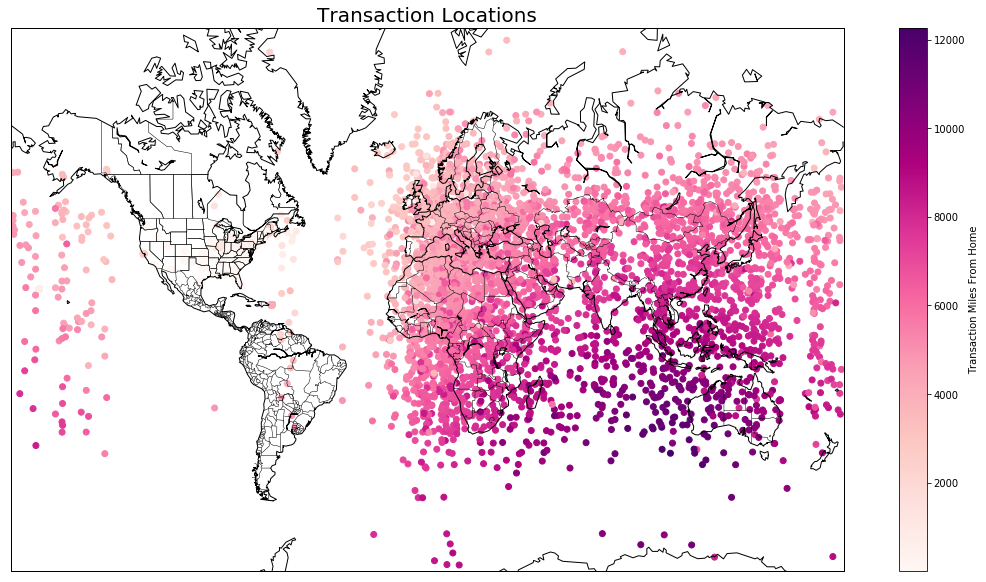

In [303]:
lat_min = table.describe().loc['min','Lat']-1
lat_max = table.describe().loc['max','Lat']+1
lon_min = table.describe().loc['min','Long']-1
lon_max = table.describe().loc['max','Long']+1
print(lat_min, lat_max, lon_min, lon_max)

from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(20,10))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)
m.drawcoastlines()
m.drawmapboundary()
#m.drawrivers()
m.drawcountries()
m.drawstates()

m.scatter(table['Long'].tolist(), table['Lat'].tolist(), c=table['distance'], cmap='RdPu', latlon=True)
plt.title('Transaction Locations', fontsize=20)
#cbar = plt.colorbar()
plt.colorbar(label='Transaction Miles From Home')
#cbar.set_label('Transaction Amount ($)', rotation=90, fontsize=20)
plt.show()

### APPARENTLY THERE ARE A LOT OF TRANSACTIONS WHOSE LAT/LONG DON'T MAKE SENSE, IN THE OCEAN, IN OTHER CONTINENTS, ETC. THEY MAY BE FRAUD TRANSACTIONS.

-69.046553453928 79.9143300311764 -180.39288734815202 180.917513484729


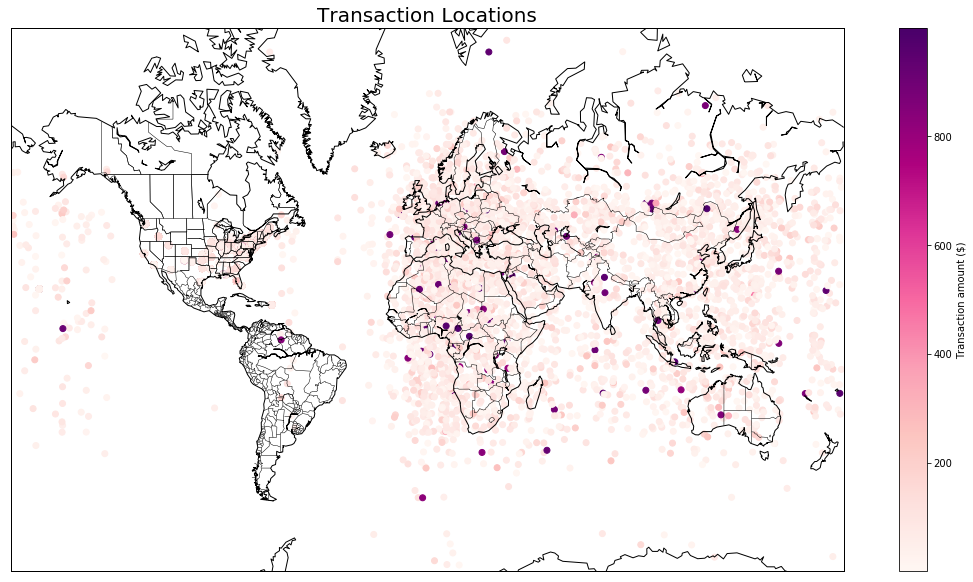

In [304]:
lat_min = table.describe().loc['min','Lat']-1
lat_max = table.describe().loc['max','Lat']+1
lon_min = table.describe().loc['min','Long']-1
lon_max = table.describe().loc['max','Long']+1
print(lat_min, lat_max, lon_min, lon_max)

from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(20,10))
m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)
m.drawcoastlines()
m.drawmapboundary()
#m.drawrivers()
m.drawcountries()
m.drawstates()

m.scatter(table['Long'].tolist(), table['Lat'].tolist(), c=table['transaction_dollar_amount'], cmap='RdPu', latlon=True)
plt.title('Transaction Locations', fontsize=20)
#cbar = plt.colorbar()
plt.colorbar(label='Transaction amount ($)')
#cbar.set_label('Transaction Amount ($)', rotation=90, fontsize=20)
plt.show()